In [1]:
pip install -q "tensorflow-text==2.8.*"

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

2022-04-24 20:34:16.175406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 20:34:16.175469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [53]:
#Open data
data_file = open('Test.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer(char_level = False)

data = data_file.lower().splitlines()

data = list(filter(lambda x: x != '##', data))

new_data = data

for paragraph in range(len(data)):
    sentences = data[paragraph].split('.')
    new_data[paragraph] = sentences
    
    
data = new_data

In [54]:
###Add start stop tokens###
start_token = '<start>'
end_token = ' <end>'
new_data = data

for paragraph in range(len(data)):
        para = data[paragraph]
        for sentence in range(len(para)):
            para[sentence] = start_token + para[sentence]
            para[sentence] = para[sentence] + end_token
        new_data[paragraph] = para

data = new_data
#data

In [55]:
num_sentences = 0

for paragraph in range(len(data)):
    num_sentences = num_sentences + len(data[paragraph])

input_sequences = np.zeros((num_sentences*2, 20))
output_sequences = np.zeros((num_sentences*2, 20))

In [44]:
def Encode_Inputs(data, max_sentence_length):
    filled = 0
    filled2 = 0
    
    for paragraph in range(len(data)):
        para = data[paragraph]

        tokenized_sentence = para
        tokenizer.fit_on_texts(tokenized_sentence)

        #Transforms sentences into set of integers from the dictionary
        tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)

        #Pad sequences to length of max_length
        tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = 20, padding ='post', value = 0)
        total_words = len(tokenizer.word_index) + 1    

        roll_amount = tokenized_sentence.shape[1] * (tokenized_sentence.shape[0]-1)
        output_tokens = np.array(np.roll(tokenized_sentence, roll_amount))
        output_tokens[-1] = 0

        for sentence in range(len(tokenized_sentence)):
            input_sequences[filled+sentence] = tokenized_sentence[sentence]

            filled = filled + 1

        for sentence in range(len(tokenized_sentence)):
            output_sequences[filled2+sentence] = output_tokens[sentence]

            filled2 = filled2 + 1

    return input_sequences, output_sequences, total_words

In [45]:
def Decode_Inputs(input_sequences):
    data = tokenizer.sequences_to_texts(input_sequences)
    return data

In [57]:
max_sentence_length = 20

input_sequences, output_sequences, total_words = Encode_Inputs(data, max_sentence_length)
# print(total_words)
# print(input_sequences.shape)
# print(input_sequences)
# print()
# print(output_sequences.shape)
# print(output_sequences)
decoded = Decode_Inputs(output_sequences)

In [50]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, dropout):
        super(Transformer_Block, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.feed_forward = keras.Sequential([keras.layers.Dense(ff_dim, activation = "gelu"), keras.layers.Dense(embed_dim)])
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout)
        self.dropout2 = keras.layers.Dropout(dropout)
        
    def call(self, embedded_words, training):
        attention_output = self.attention(embedded_words, embedded_words)
        attention_output = self.dropout1(attention_output, training=training)
        #Residual connections from input to add/norm
        res1 = self.layer_norm1(embedded_words + attention_output)
        ffn_output = self.feed_forward(res1)
        ffn_output = self.dropout2(ffn_output, training=training)
        #Residual connections from add/norm to add/norm
        final_output = self.layer_norm2(ffn_output + res1)
        return final_output

In [631]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [632]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [633]:
#Pool encoder output with existing context matrix
class Multi_Head_Attention_Pooling(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dropout):
        super(Multi_Head_Attention_Pooling, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        
    #Pass in encoder as input[0], context matrix as input[1]
    def call(self, input_data):
        attention_output = self.attention(input_data[0], input_data[1])
        self_attention_output = self.attention(attention_output, attention_output)
        pooled_context = self_attention_output
        return pooled_context

In [634]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)

In [635]:
max_sentence_length = 20

input_sequences, total_words = Encode_Inputs(data, max_sentence_length)
print(total_words)
print(input_sequences.shape)
print(input_sequences)

decoded = Decode_Inputs(input_sequences)
decoded

23
(4, 20)
[[ 2  3  4  5  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  8  9 10 11 12 13  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [14 15 16  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 18 19 20 21 22  1  0  0  0  0  0  0  0  0  0  0  0  0  0]]


['<start>the important thing is not to stop questioning <end> <start> curiosity has its own reason for existence <end> <start> one cannot help but be in awe when he contemplates the mysteries of eternity, of life, of the marvelous structure of reality <end> <start> it is enough if one tries merely to comprehend a little of this mystery each day <end> <start> <end>',
 '<start> your letter made me very happy <end> <start> i would like to come back to the matter of the skimpy birdfeed when i return to zurich <end> <start> at the moment i have to leave on a business trip <end> <start> if i can arrange it, i’ll go to arosa for a couple of days to see tete <end> <start> when adn arrived yesterday with the letter, i was here, but they didn’t look for me properly <end> <start> my train leaves in 2 hours <end> <start> as regards health, incidentally, i am feeling infinitely better than last year <end> <start>  <end>',
 '<start>with brilliant sunshine and sweet chocolate, it’s grand to read abou

In [636]:
output_sequences = Create_Output_Sequences(input_sequences)
print(output_sequences.shape)
print(output_sequences)

decoded = Decode_Inputs(output_sequences)
decoded

(4, 20)
[[ 7  8  9 10 11 12 13  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [14 15 16  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 18 19 20 21 22  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


['<start> your letter made me very happy <end> <start> i would like to come back to the matter of the skimpy birdfeed when i return to zurich <end> <start> at the moment i have to leave on a business trip <end> <start> if i can arrange it, i’ll go to arosa for a couple of days to see tete <end> <start> when adn arrived yesterday with the letter, i was here, but they didn’t look for me properly <end> <start> my train leaves in 2 hours <end> <start> as regards health, incidentally, i am feeling infinitely better than last year <end> <start>  <end>',
 '<start>with brilliant sunshine and sweet chocolate, it’s grand to read about the goings on in berlin from up here <end> <start> monday the schoolmastering begins <end> <start> this nest zuoz is unbelievably attractive architecturally <end> <start>  <end>',
 '<start>sparkling scenery and well-fed citizens who have nothing to fear <end> <start> that is what it looks like here <end> <start> but god knows, i like people with cares, to whom the 

In [471]:
#Variables
embed_dim = 128
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 8 
ff_dim = 16
dropout = 0.15
num_seeds = 20

encoder_stack = 1
decoder_stack = 1

In [515]:
#Initialize context matrix
context_encoder = tf.random.uniform(shape=(1, num_seeds, embed_dim))
context_decoder = tf.random.uniform(shape=(1, num_seeds, embed_dim))

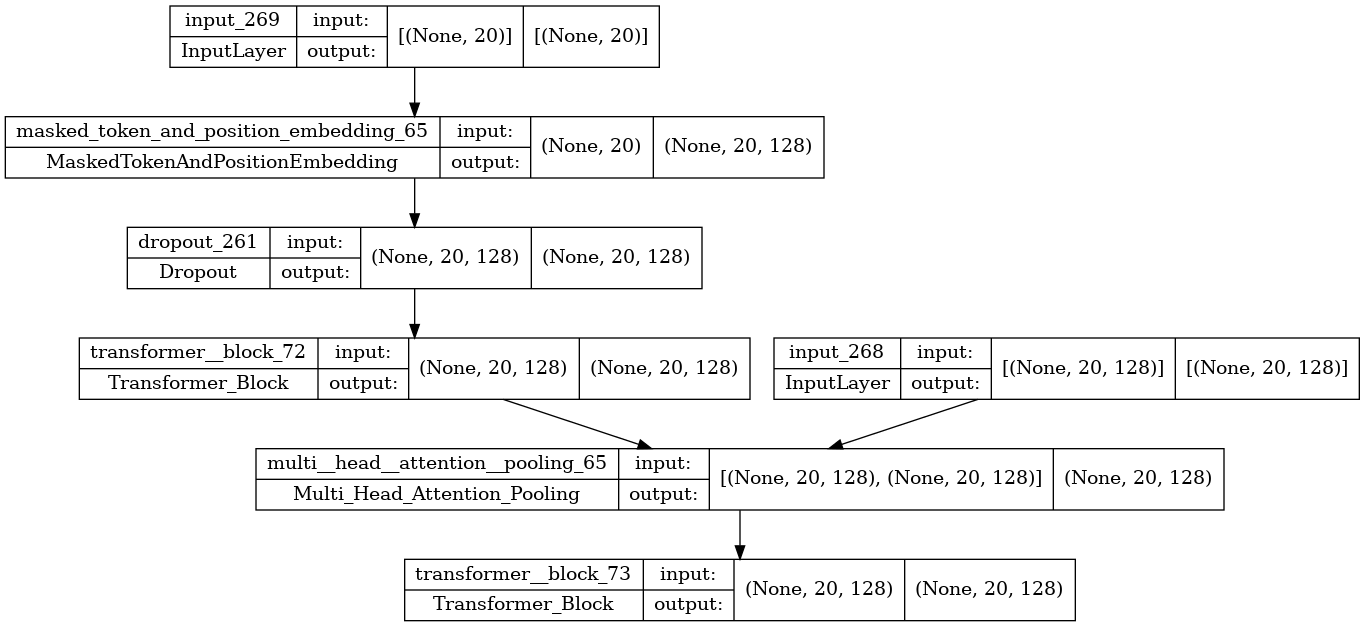

In [518]:
#Encoder

#Create layer for context
context_encoder_layer = keras.layers.Input(shape=context_encoder.shape[1:])

#Sequence input
input_layer = keras.layers.Input(shape=input_sequences.shape[1])
position_embedding_layer =  MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout
dropout = keras.layers.Dropout(dropout,noise_shape=position_embedding_layer.shape[:-1]+(1,))(position_embedding_layer)
encoder = dropout

for i in range(encoder_stack):
    encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(encoder)

context_encoder = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([encoder, context_encoder_layer])
                                                                                                  
encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(context_encoder)

encoder_model = keras.Model([input_layer, context_encoder_layer], encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

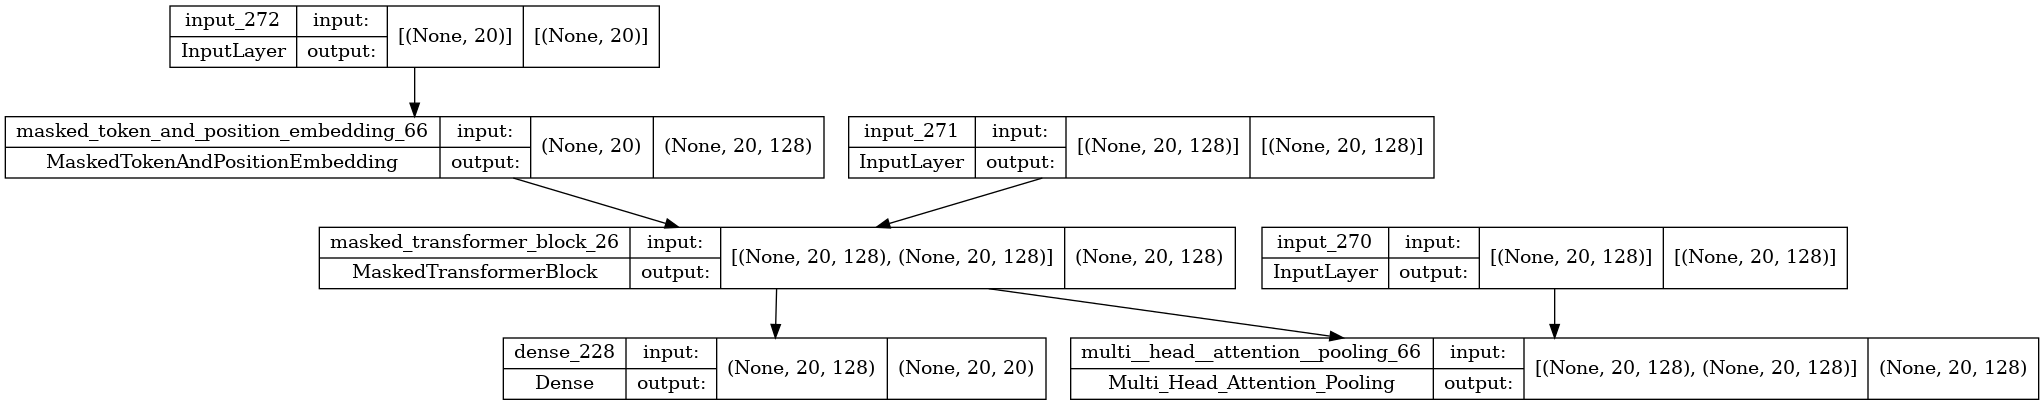

In [519]:
#Decoder 

#Context input_layer
context_decoder_layer = keras.layers.Input(shape=context_decoder.shape[1:])

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = output_sequences.shape[1])
position_embedding_layer = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(max_sentence_length)(decoder)

#Output of decoder/linear layer? should go to update context matrix with pooling
context_decoder = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([decoder, context_decoder_layer])

decoder_model = keras.Model([input_layer, encoder_input_layer, context_decoder_layer], [linear_layer, context_decoder])
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

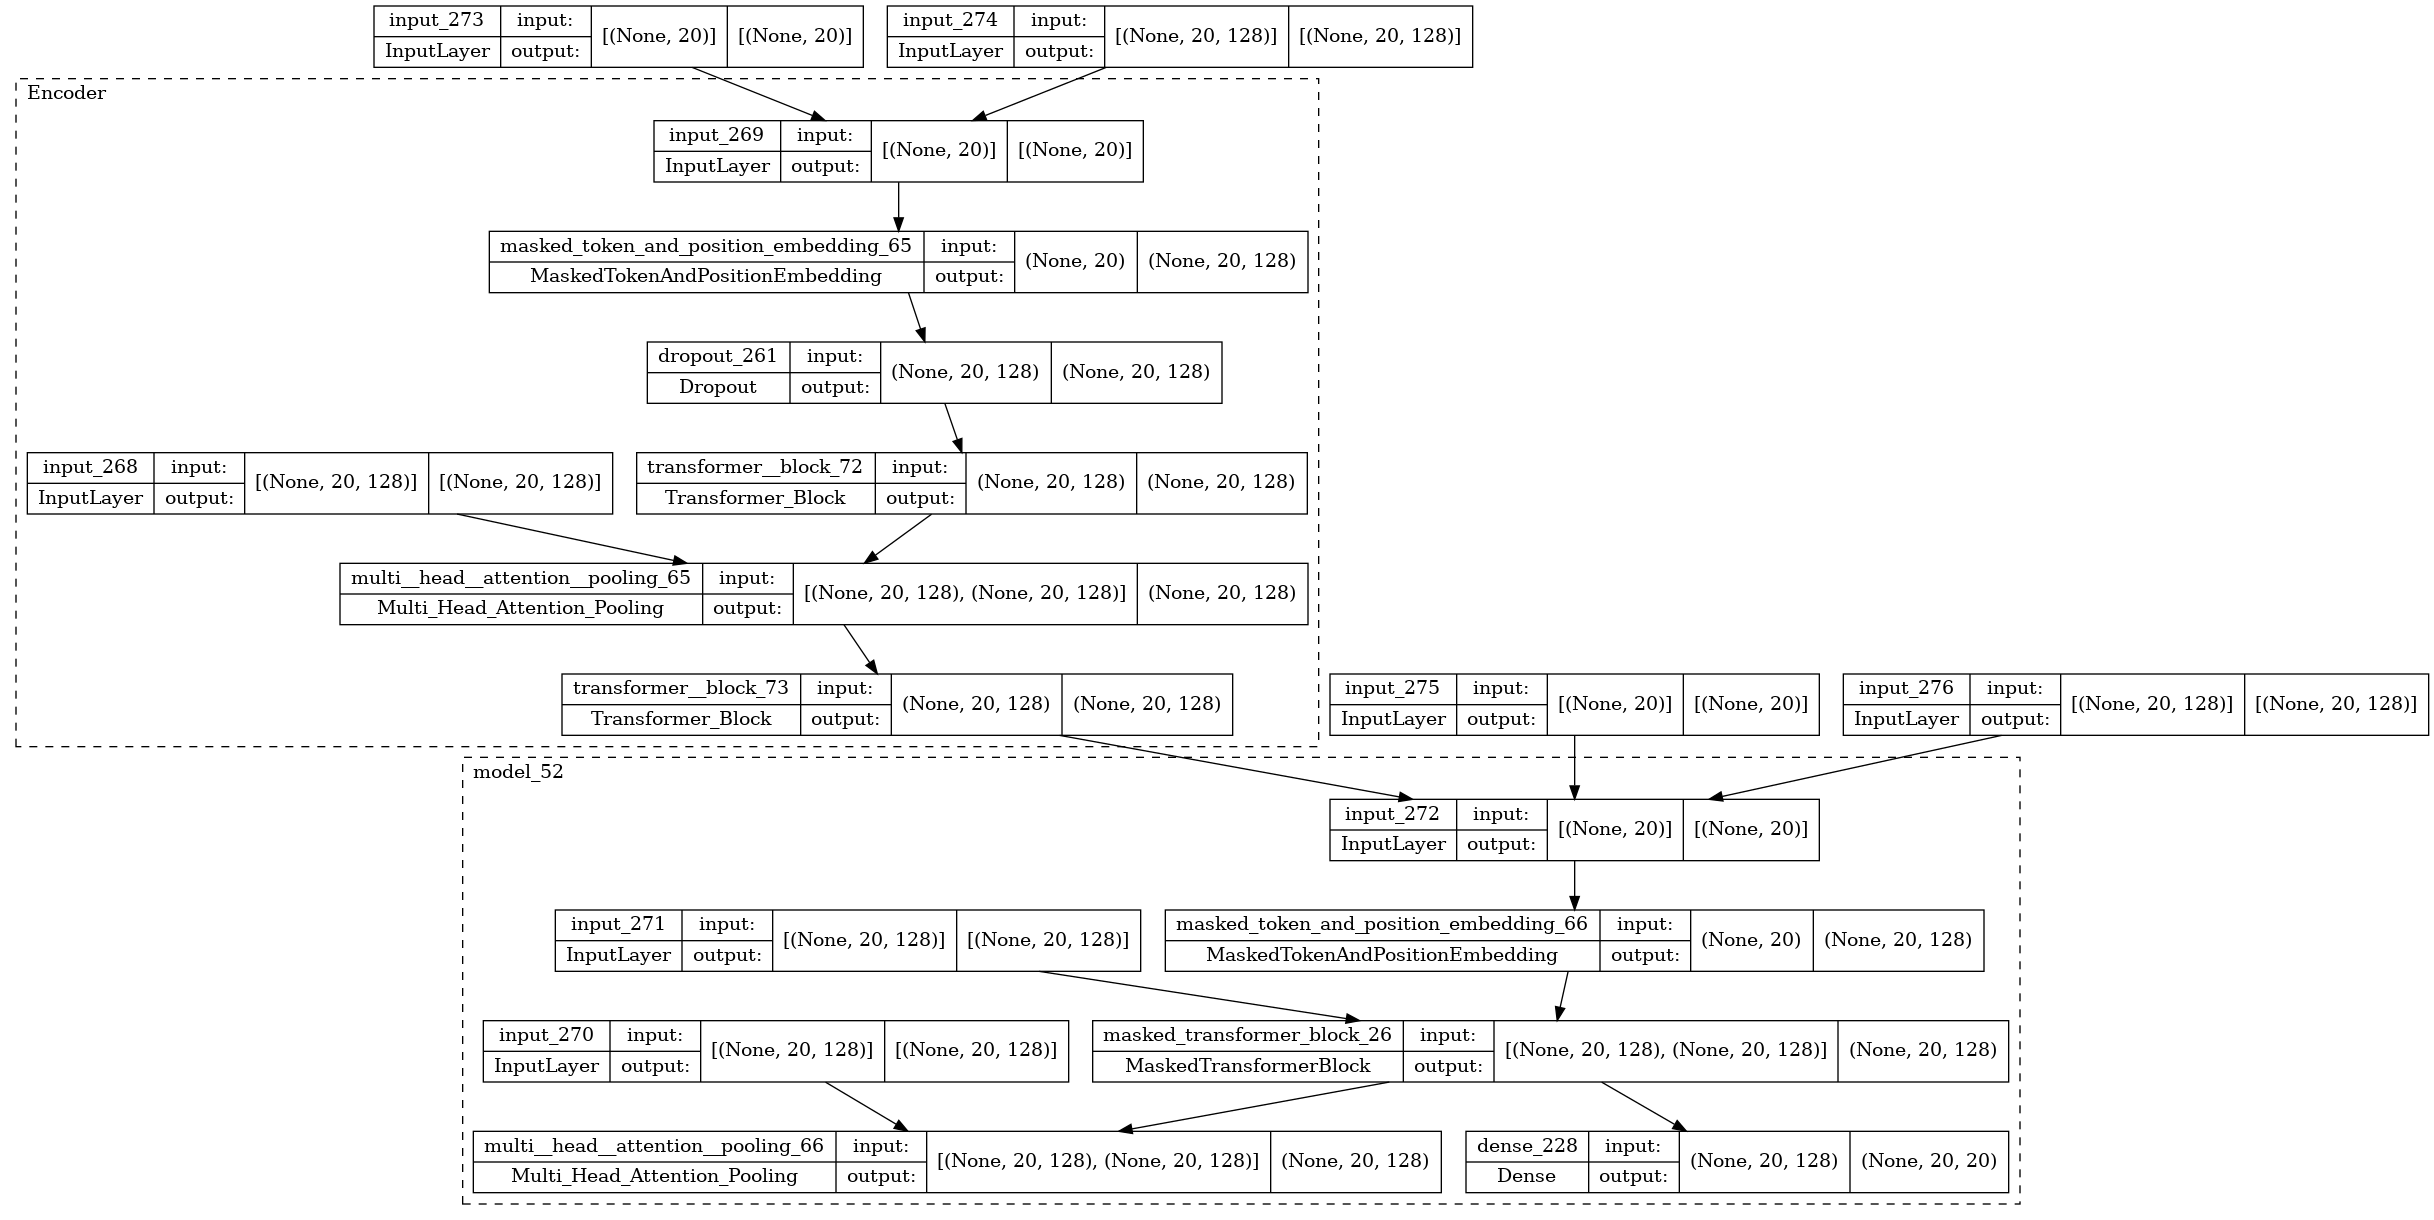

In [520]:
sequences = keras.layers.Input(encoder_model.input_shape[0][1:])
context_encoder_input = keras.layers.Input(encoder_model.input_shape[1][1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])
context_decoder_input = keras.layers.Input(decoder_model.input_shape[2][1:])



transformer = decoder_model([targets, encoder_model([sequences, context_encoder_input]), context_decoder_input])
transformer = keras.Model([sequences, context_decoder_input, targets, context_encoder_input], transformer)


keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [521]:
transformer.compile(loss=MaskedSparseCategoricalCrossentropy, optimizer=keras.optimizers.Adam(), metrics=[MaskedSparseCategoricalAccuracy])
transformer.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_273 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 input_274 (InputLayer)         [(None, 20, 128)]    0           []                               
                                                                                                  
 input_275 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 Encoder (Functional)           (None, 20, 128)      1600672     ['input_273[0][0]',              
                                                                  'input_274[0][0]']       

In [522]:
batch_size = 1
epochs = 150
history = transformer.fit((input_sequences, context, output_sequences, context), [output_sequences], batch_size=batch_size, epochs=epochs, verbose=0)

ValueError: Data cardinality is ambiguous:
  x sizes: 5, 20, 5, 20
  y sizes: 5
Make sure all arrays contain the same number of samples.